In [ ]:
import os
import fnmatch
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import interp
from itertools import cycle
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [2]:
class Instance:
    def __init__(self,dataframe,activity,dataset_type):
        """ Creates Instance objects and assigns the important data elements
        Parameters
        ----------
        dataframe : pandas dataframe, frame representing the time series data associated with this instance 
        activity : str, activity label
        dataset_type : str, indicates whether instance is training or testing
        Results
        ---------
        returns object of class Instance
        """
        self.dataframe = dataframe
        self.activity = activity
        if dataset_type == 'training':
            self.type = 'training'
        else:
            self.type = 'testing'
       
    def add_activity(self,frame):
        """ Adds the activity label to a dataframe
        Parameters
        ----------
        frame : pandas dataframe, frame to add activity label to 
        Results
        ---------
        returns pandas dataframe, frame
        """
        frame['activity'] = pd.Series([self.activity for i in range(len(frame.index))], 
                                          index = frame.index)
        return frame
    
    def rename_columns(self, frame, feature):
        """ Helper function to rename time series columns to correspond to a specific feature
        Parameters
        ----------
        frame : pandas dataframe, frame to change column names
        feature : string, indicates the feature used for renaming the time series columns 
        Results
        ---------
        returns pandas dataframe, frame
        """
        col_names = [i for i in frame.columns]
        new_cols = [feature + '_' + i for i in col_names]
        frame.columns = new_cols
        return frame
        
    def featurize(self, classify, split_frames = None, select_vars = None):
        """ Calculates the features of the instance and stores it in a dataframe
        Parameters
        ----------
        classify : boolean, param set to add class labels to feature dataframe
        split_frames: list, contains split time series frames used for logistic regression 
        select_vars : list, optional param to specify variables to select in feature dataframe
                select_vars = None means keep all the variables 
        Results
        ---------
        returns pandas dataframe, feature_dataframe
        """
        if split_frames == None:
            min_frame = pd.concat([self.dataframe.min()],axis = 1).transpose()
            max_frame = pd.concat([self.dataframe.max()],axis = 1).transpose()
            mean_frame = pd.concat([self.dataframe.mean()],axis = 1).transpose()
            median_frame = pd.concat([self.dataframe.median()],axis = 1).transpose()
            std_frame = pd.concat([self.dataframe.std()],axis = 1).transpose()
        else:
            min_frame = pd.concat([split_frames[i].min() for i in range(len(split_frames))], axis = 1).transpose()    
            max_frame = pd.concat([split_frames[i].max() for i in range(len(split_frames))], axis = 1).transpose()
            mean_frame = pd.concat([split_frames[i].mean() for i in range(len(split_frames))], axis = 1).transpose()
            median_frame = pd.concat([split_frames[i].median() for i in range(len(split_frames))], axis = 1).transpose()
            std_frame = pd.concat([split_frames[i].std() for i in range(len(split_frames))], axis = 1).transpose()
            
        #Renames the columns so it is easier to identify
        min_frame = self.rename_columns(min_frame,"Min")
        max_frame = self.rename_columns(max_frame,"Max")
        mean_frame = self.rename_columns(mean_frame,"Mean")
        median_frame = self.rename_columns(median_frame,"Median")
        std_frame = self.rename_columns(std_frame,"STD")
        
        #Creates a feature dataframe
        feature_dataframe = pd.concat([min_frame, max_frame, mean_frame,median_frame,std_frame], axis = 1)
        
        if classify == False:
            return feature_dataframe #No activity labels for bootstrap         
        elif classify == True:
            feature_dataframe = self.add_activity(feature_dataframe) #Adds activity label to frame
            if select_vars is None:
                return feature_dataframe
            else:            
                #data_vars = feature_dataframe.columns.values.tolist()
                #keep_vars = [i for i in data_vars if i not in remove_vars]
                return feature_dataframe[select_vars]      
        
    def break_timeSeries(self,l,select_vars = None):
        """Breaks time series of instance into equal length time series defined by l
        Parameters
        ----------
        l : integer, number of equal length segments to break time series dataframe into 
        select_vars : list, optional param to specify variables to select in feature dataframe
                select_vars = None means keep all the variables 
        Results
        ---------
        returns pandas dataframe, feature_dataframe
        """
        df_split = np.array_split(self.dataframe,l) #list of split time series frames
        split_frame = self.featurize(True, split_frames = df_split, select_vars = select_vars)
        return split_frame

The way I am reading in the dataset into a pandas dataframe is that I am using the time variable as the indexed column for my dataset. Therefore, each dataset is indexed with the time range of (0,119750). This means that there are 6 columns of data corresponding to the features of each instance. 

In [3]:
def read_data(activity):
    """Reads in datasets for all activity folders located in the directory path, instantiates instance objects,
    lables instances and categorizes instances as training or testing
    Parameters
    ----------
    activity : string, name of the activity folder where instances should be instantiated from   
    Results
    ---------
    returns list of objects belong to the Instance Class, instance_list
    """
    #col names that are common among all datasets
    col_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
    path = "."
      
    if os.path.isdir(activity):
        dirpath = os.path.join(path,activity)
        number_files = len(fnmatch.filter(os.listdir(dirpath), '*.csv'))
        if activity == "bending1" or activity =="bending2":
            test_list = ['dataset%s.csv' % i for i in range(1,3)] 
            train_list = ['dataset%s.csv' % i for i in range(3,number_files + 1)]
        else:
            test_list = ['dataset%s.csv' % i for i in range(1,4)]
            train_list = ['dataset%s.csv' % i for i in range(4,number_files + 1)]
        
        #converts data from datasetID.csv into pandas dataframe and stores in a data frame list
        dftrain_instances = [Instance(pd.read_csv(os.path.join(activity, fname), sep = ',', skiprows = 5, 
                                                  index_col = 0, header = None, names = col_names), 
                                      activity,'training') for fname in train_list]
        dftest_instances = [Instance(pd.read_csv(os.path.join(activity, fname), sep = ',', skiprows = 5, 
                                                 index_col = 0, header = None, names = col_names), 
                                     activity,'testing') for fname in test_list]           
        instance_list = dftest_instances + dftrain_instances
        return instance_list       
            

In [4]:
#List of activity names and corresponding folder names
activity_names = ['bending1','bending2','cycling','lying','sitting','standing','walking']

#Returns a list of a list 
instances = [read_data(name) for name in activity_names]

#Unpacks the list of lists and creates one global instance_list 
instance_list = list(itertools.chain.from_iterable(instances))

After researching time-domain features that are usually used in time series classification, I decided to choose the following for the rest of the time-series analysis:
1) Minimum
2) Maximum
3) Mean
4) Median
5) Standard deviation
I then extracted the time-domain features for all the 6 time series in each instance.

In [5]:
#Feature Frame should be of shape (88,18) with 88 instances and 18 predictors
feature_frame = pd.concat([instance_list[i].featurize(False) for i in range(len(instance_list))])

I then estimate the standard deviation of each of the time-domain features I extracted from the data. To get an understanding of the features that have the largest variance, I made a barplot seen below.

Feature		Esimated Standard Dev



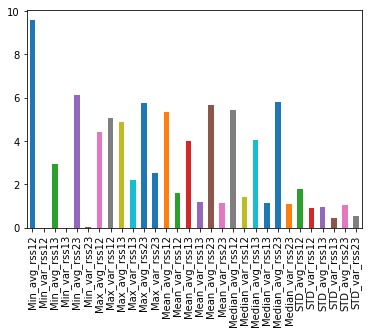

In [6]:
#Prints out the estimates of standard deviation 
print('Feature\t\tEsimated Standard Dev\n')
feature_frame.std().plot(kind = 'bar')
#print(feature_frame.std())

Bootstrapping the standard deviations of the features 

In [7]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = np.array(X[resample_i])  # TODO: write a test demonstrating why array() is important
    return X_resample


The code below prints out the bootstrapped confidence intervals for the features from the time series data 

In [8]:
def Bootstrap(feature_frame, N):
    """ Performs a Bootsrap, and calculates bootsrap confidence intervals for the standard deviation of
    each feature
    Parameters
    ----------
    feature_frame : pandas dataframe, 
    N : int, number of bootstraps to perform
    Results
    -------
    prints Confidence Intervals
    """
    bootstraps = []
    for n in range(N):      
        resampled = pd.DataFrame(index=feature_frame.index, columns=feature_frame.columns) #Empty dataframe
        #fills the empty dataframe with resampled values from the population set 
        for col in feature_frame.columns:
            resampled[col] = bootstrap_resample(feature_frame[col])
                          
        std = resampled.std() #Calculates the bootstrap std for each resampled time series dataframe
        bootstraps.append(std) #Adds std to list
    
    bootstrapped = pd.concat(bootstraps, axis = 1).transpose() #Bootstrapped dataframe

    #Gets the 95% confidence interval of each time series in the bootstrapped dataframe
    alpha = 0.95
    low_q = ((1.0-alpha)/2.0) 
    upper_q = (alpha+((1.0-alpha)/2.0))                                       
    low = bootstrapped.quantile(low_q) #Upper quantile
    upper = bootstrapped.quantile(upper_q) #Lower quantile
   
    for i in range(len(low)):
        print('CI for %s : (%f,%f)' % (low.index[i],low[low.index[i]],upper[upper.index[i]]))
    

In [9]:
print('Bootstrapped 95% Confidence Intervals for Standard Deviations of Each Feature\n')
Bootstrap(feature_frame,100)

Bootstrapped 95% Confidence Intervals for Standard Deviations of Each Feature

CI for Min_avg_rss12 : (8.565859,11.196763)
CI for Min_var_rss12 : (0.000000,0.000000)
CI for Min_avg_rss13 : (2.705418,3.132476)
CI for Min_var_rss13 : (0.000000,0.000000)
CI for Min_avg_rss23 : (4.079719,7.769096)
CI for Min_var_rss23 : (0.000000,0.078476)
CI for Max_avg_rss12 : (3.448035,5.489596)
CI for Max_var_rss12 : (4.641492,5.409990)
CI for Max_avg_rss13 : (4.113944,5.574161)
CI for Max_var_rss13 : (1.981834,2.398700)
CI for Max_avg_rss23 : (4.763540,6.741223)
CI for Max_var_rss23 : (2.188813,2.797022)
CI for Mean_avg_rss12 : (4.592053,6.198269)
CI for Mean_var_rss12 : (1.368324,1.696700)
CI for Mean_avg_rss13 : (3.339292,4.656811)
CI for Mean_var_rss13 : (1.051734,1.229196)
CI for Mean_avg_rss23 : (4.289508,7.011722)
CI for Mean_var_rss23 : (1.061397,1.224747)
CI for Median_avg_rss12 : (4.770475,6.041320)
CI for Median_var_rss12 : (1.214524,1.554197)
CI for Median_avg_rss13 : (3.357488,4.634957)
CI

Based on the boostrapped confidence intervals shown above for the standard deviation estimate of each of the features extracted from the time series data, we are looking for small values for standard deviation that have a small range of variation, so we can be more confident about the results of our classification tasks. Out of the five features selected, the three best features overall seem to be Mean, Median and Standard deviation!

In the next section, I set up a binary classification problem where I want to classify bending from other activities. Before I perform the classification, I want to visualize my data better so I create a scatter plot of the features I specified in the previous section and use colors red and blue to specifiy the data points as either bending or other activities respectively. The plot includes only Time Series 1,2 and 6

In [10]:
def plot_scatter(feature_frame, title):
    """ Creates a scatter plot of the features specified in the given feature frame
    Parameters
    ----------
    feature_frame : pandas dataframe, the frame for the scatter plot
    title: string, specifies the title of the plot
    Results
    -------
    returns a scatter plot of features
    """
    col_names = [i for i in feature_frame.columns if i!= 'activity'] #['avg_rss12','var_rss12,'var_rss23']
    col_nums = list(range(len(col_names)))

    #list to help indicate the data points belonging to bending class from the other classes
    color = ['r' if row['activity'] in ['bending1','bending2'] else 'b' for index, row in feature_frame.iterrows()]

    fig, ax = plt.subplots(figsize=(15, 10))
    for i in range(len(col_nums)):
        nums = [col_nums[i] for x in range(len(feature_frame.index))]
        x = np.asarray(nums)
        ax.scatter(x,feature_frame.iloc[:,i], c = color)
        ax.set_xlabel('Time Series Feature', fontsize = 20)
        ax.set_xticks(col_nums)
        ax.set_xticklabels(col_names, fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    plt.xticks(rotation = 90)
    plt.title(title,fontsize = 20)
    plt.show()

In [11]:
#Splits up instance list into training and testing instance lists for classification
training_instances = [instance for instance in instance_list if instance.type == 'training']
testing_instances = [instance for instance in instance_list if instance.type == 'testing']

#Specifies the variables to keep
select_vars = ['Mean_avg_rss12','Mean_var_rss12','Mean_var_rss23',
               'Median_avg_rss12','Median_var_rss12','Median_var_rss23',
               'STD_avg_rss12','STD_var_rss12','STD_var_rss23','activity']

In [12]:
#Train Frame should have shape (69,10): 69 training instances and 9 features with 1 column of activity type
train_frame = pd.concat([training_instances[i].featurize(True,split_frames = None, select_vars = select_vars) 
                         for i in range(len(training_instances))])

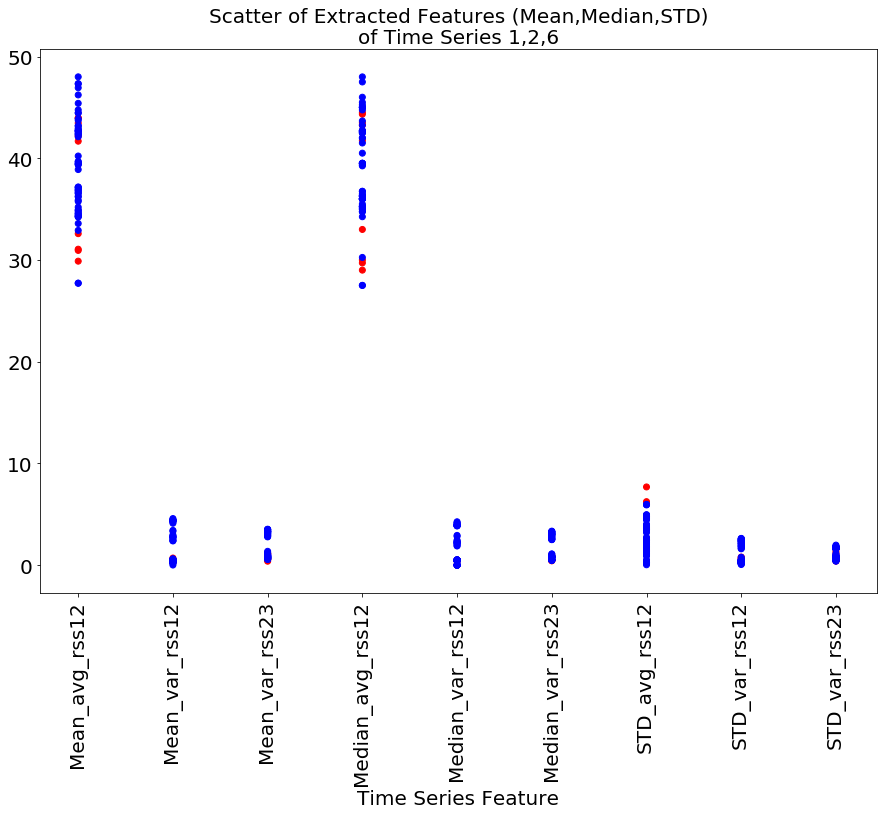

In [13]:
#Creates the feature dictionary then plots the scatter plots
plot_scatter(train_frame,"Scatter of Extracted Features (Mean,Median,STD)\nof Time Series 1,2,6")

Since there are only 88 instances in our sample, I decided to break each time series in the training set into two approximately equal length time series to see if that had any effect on the variability seen in the data. One thing to keep in mind is that we cannot sample randomly from our data because it is a time series and we would lose valuable information if we did that. 

In [14]:
#Train Split frame contains the feature frame after time series split of l=2
train_splitFrame = pd.concat([training_instances[i].break_timeSeries(2,select_vars = select_vars) 
                         for i in range(len(training_instances))])

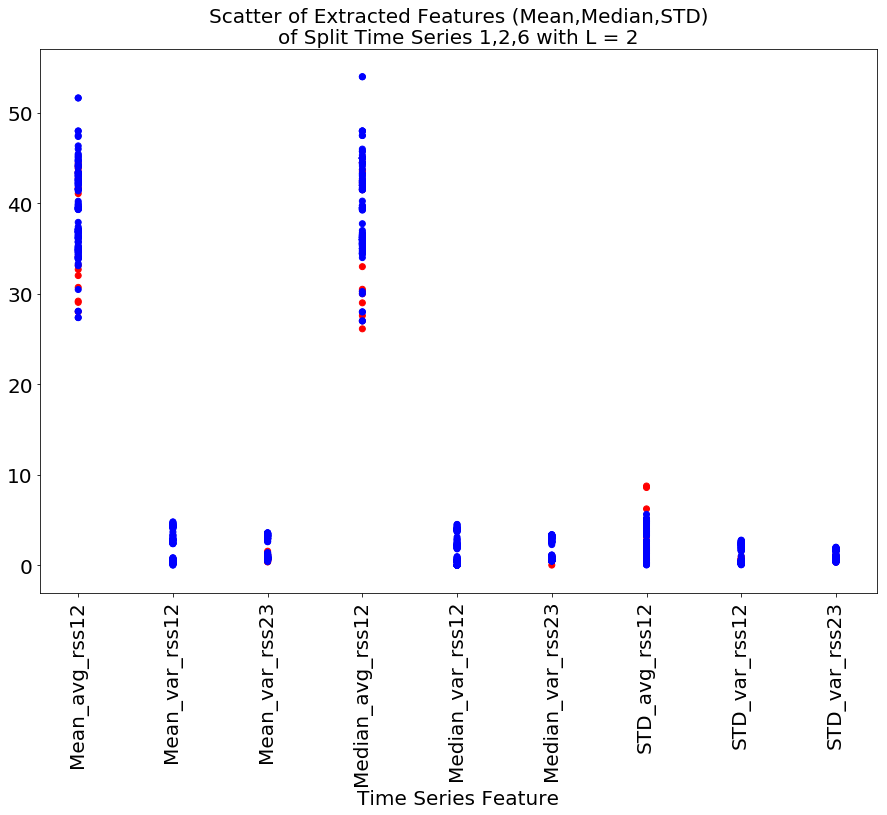

In [15]:
#Plots the scatter plot of the split time series 
plot_scatter(train_splitFrame,"Scatter of Extracted Features (Mean,Median,STD)\nof Split Time Series 1,2,6 with L = 2")

There is not much of a difference between the two graphs, but splitting the time series data into more instances gives a slightly higher variance of the each of the time domain features.

The next section explores the binary classification problem, by breaking the time series data into l = {1,2,3,4...10} time series of approximately equal length and fitting the data to a logistic regression model for classificiation. For each value of l I will calculate the corresponding p-values for the logistic regression parameters and report the cross validation accuracy in order to choose the best split l. After determing the best split l and the pruned features associated with that logistic regression model, I will refit the logistic regression model and test the model on the testing data. 

In [16]:
def binarize(x):
    """ Binarizes the data giving a 1 to instances labeled as bending activity and 0 to instances labeled as other activities
    Parameters
    ----------
    X : data instance 
    Results
    -------
    returns 0 or 1
    """
    if x in ['bending1','bending2']:
        return 1
    else:
        return 0

In [17]:
def p_values(X,Y):
    """ Calculates the p values for the given X and Y data, using stats model Logit classifier
    Parameters
    ----------
    X : pandas dataframe, set of predictors to feature select 
    Y: pandas dataframe, response variable to fit model
    Results
    -------
    returns pandas.Series, pvalues
    """
    X = sm.add_constant(X, prepend=True) #Adds a constant
    logit_model = sm.Logit(Y,X)
    result=logit_model.fit(method='bfgs')
    return result.pvalues    

In [18]:
def prune_features(X,Y,selection):
    """ Prunes the features to get the best predictors using Recursive feature selection RFE
    Parameters
    ----------
    X : pandas dataframe, set of predictors to feature select 
    Y: pandas dataframe, response variable to fit model
    selection: string, indicates the type of feature selection to be performed 'L1CV' or 'RFE'
    Results
    -------
    returns pruned data, if L1CV also return C value for hyperparameter
    """
    col_vals = X.columns.values.tolist()
    if selection == 'L1':
        
        lsvc = LogisticRegressionCV(penalty = 'l1', dual = False, solver = 'liblinear', Cs = np.linspace(0.001, 100, 50), 
                                    refit = True, max_iter = 2000).fit(X, Y)
        #Feature Selection
        model = SelectFromModel(lsvc, prefit=True)      
        support = list(model.get_support())
        hyper_c = lsvc.C_[0]
    elif selection == 'Multinomial':  
        lsvc = LogisticRegressionCV(penalty = 'l1', dual = False, solver = 'saga', Cs = np.linspace(0.001, 100, 50), 
                                    multi_class = 'multinomial', refit = True, max_iter = 2000).fit(X, Y)

        #print feature_importances_
        model = SelectFromModel(lsvc, prefit=True)
        support = list(model.get_support())
        hyper_c = lsvc.C_[0]
    
    elif selection == 'Log Reg': 
        logreg = LogisticRegression()
        model = RFE(logreg).fit(X,Y)
        support = list(model.support_)
     
    index = [i for i, x in enumerate(support) if x]
    pruned_features = [col_vals[i] for i in index]
    
    if selection == 'L1' or selection == 'Multinomial':
        return X[pruned_features], hyper_c
    else:
        return X[pruned_features]
     

In [19]:
def instance_split(instances,l,binary = True):
    """ Splits instances according to value of l and returns the X,Y dataframes for model fitting
    Parameters
    ----------
    instances : list, elements are instances of the dataset 
    l: int, value indicating the number of breaks in time series data
    binarize: boolean, option to for binary classification of multinomial
    Results
    -------
    returns X,Y
    """
    dataframe = pd.concat([instances[i].break_timeSeries(l,select_vars = None) 
                                 for i in range(len(instances))])
    if binary == True:
        dataframe['class'] = dataframe['activity'].apply(binarize) #new column for binary classification
        data_vars = dataframe.columns.values.tolist()
        remove_vars = ['activity']
        final_vars = [i for i in data_vars if i not in remove_vars]

        final_data = dataframe[final_vars]
        target_vars = ['class']
        predictor_vars = [i for i in final_vars if i not in target_vars]

        X = final_data[predictor_vars]
        Y = final_data['class']
    else:
        data_vars = dataframe.columns.values.tolist()
        target = ['activity']
        predictor_vars = [i for i in data_vars if i not in target]

        X = dataframe[predictor_vars]
        Y = dataframe[target]
        
    return X,Y

The Code below is used to find the best logistic regression model in terms of p-values and cross validation accuracy for different values of l defining the number of splits in time series data. 

In [20]:
def best_split(training_instances, classifier):
    """ Determines the best split length to perform on the time series data based on which classification model we are trying to 
    determine the best split for. 
    Parameters
    ----------
    training_instnaces : list, elements are instances of the dataset 
    classifier : string, indicates which classifier we are determing the best split length for
    Results
    -------
    returns dict of the split models with the split number as key
    """
    split_models = {}
    splits = [i for i in range(1,11)]
    for l in splits:
        X,Y = instance_split(training_instances,l, binary = True) #breaks up time series  
        if classifier == 'L1':
            X_scaled = normalize(X)
            X_scaled = X_scaled.dropna(axis=1,how='all') #removes all columns with NA values
            X_pruned, param = prune_features(X_scaled,Y,classifier) #param is C value
            parameter = 'C value'
            logreg = LogisticRegression(C = param, penalty = 'l1', dual = False, solver = 'liblinear')
        else:
            X_pruned = prune_features(X,Y,classifier)
            param = p_values(X_pruned,Y) #param is p-values
            parameter = 'P value'
            logreg = LogisticRegression()
            
        predicted = cross_val_predict(logreg, X_pruned, Y, cv = 5)
        accuracy = metrics.accuracy_score(Y, predicted)*100
        split_models[l] = {parameter : param, 'Cross Val Accuracy': accuracy, 'Pruned Features': X_pruned}
    
    return split_models
        

In [21]:
def display_split_models(split_models, classifier, sort_by = 'Cross Val Accuracy'):
    """ Displays the split models and default sorts them by highest cross val accuracy to lowest to see which split length is the
    best for the specified classifier. 
    Parameters
    ----------
    split_models : dict, results from split model with the split number as key
    classifier : string, indicates which classifier we are determing the best split length for
    Results
    -------
    returns display of cross val dataframe and the parameters dataframe, which could by p-values or C hyperparameter values
    """
    split = [key for key in split_models.keys()]
    cross_score = [split_models[key]['Cross Val Accuracy'] for key in split]
    if classifier == 'Log Reg':
        param = [split_models[key]['P value'] for key in split]
        pval = pd.concat([param[i] for i in range(len(param))], axis = 1)
        print("P Value Table")
        display(pval)
        df_ = pd.DataFrame(data = np.zeros(shape = (len(split),2)), columns = ['Number of Splits', 'Cross Val Accuracy'])
        for ii in range(0,len(split)):
            df_.loc[ii, 'Number of Splits'] = int(split[ii])
            df_.loc[ii, 'Cross Val Accuracy'] = cross_score[ii]
        
    if classifier == 'L1':
        param = [split_models[key]['C value'] for key in split]
        df_ = pd.DataFrame(data = np.zeros(shape = (len(split),3)), columns = ['Number of Splits', 'Cross Val Accuracy',
                                                                               'C value'])
        for ii in range(0,len(split)):
            df_.loc[ii, 'Number of Splits'] = int(split[ii])
            df_.loc[ii, 'Cross Val Accuracy'] = cross_score[ii]
            df_.loc[ii, 'C value'] = param[ii]
    
    # Display the Dataframe
    display(df_.sort_values(by=sort_by, ascending=False))
    
    

In [22]:
def normalize(df):
    """Normalizes the data in the df dataframe into a range from [0,1]
    Parameters
    ----------
    df : pandas dataframe, representing the dataframe to normalize 
    Results
    -------
    returns pandas dataframe, normalized
    """
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
best_logreg = best_split(training_instances,'Log Reg')

In [24]:
display_split_models(best_logreg, 'Log Reg')

P Value Table


,0,1,2,3,4,5,6,7,8,9
Max_avg_rss12,NaN,0.451548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max_avg_rss13,NaN,0.233583,0.045904,0.011740,0.012764,0.071479,6.873373e-02,7.284123e-02,1.180668e-01,NaN
Max_avg_rss23,0.999997,0.216890,0.040668,0.120168,0.078605,0.021254,1.213766e-01,1.259330e-02,5.016857e-02,1.411816e-04
Max_var_rss12,0.999999,0.939381,NaN,0.773165,NaN,NaN,NaN,3.400076e-01,NaN,4.144343e-01
Max_var_rss13,NaN,NaN,NaN,0.332277,0.031248,0.078595,1.425659e-01,3.787680e-01,1.645600e-01,1.448787e-01
Max_var_rss23,1.000000,NaN,NaN,NaN,NaN,NaN,1.719068e-01,NaN,NaN,NaN
Mean_avg_rss12,1.000000,0.192044,0.012016,0.000414,0.000222,0.000003,7.751992e-08,NaN,NaN,NaN
Mean_avg_rss13,NaN,0.804309,0.133894,NaN,0.053551,0.073052,7.453866e-02,NaN,2.931937e-02,2.280769e-02
Mean_avg_rss23,1.000000,NaN,NaN,NaN,0.108978,0.435437,1.739579e-02,NaN,1.639389e-01,7.104451e-02
Mean_var_rss12,1.000000,0.920194,0.733024,0.821248,0.297533,0.684319,6.467247e-01,7.199543e-01,5.600244e-01,6.446066e-01


,Number of Splits,Cross Val Accuracy
0,1.0,98.550725
1,2.0,92.753623
8,9.0,92.592593
5,6.0,92.512077
2,3.0,92.270531
6,7.0,92.132505
3,4.0,92.028986
7,8.0,91.666667
4,5.0,91.304348
9,10.0,91.159420


By observing the p-values along with the cross validation accuracy of the different subsets, it looks like a value of l = 9 is the best. It has a cross validation accuracy of 92.59% with all of the p-values being very low meaning that all of the feature predictors are statistically significant. Therefore I will use the set of pruned features associated with l = 9 for the rest of this problem. 

In [25]:
def show_ROC(Y, predict_probs,roc_auc, sample):
    """Plots the ROC Curve
    Parameters
    ----------
    Y, predict_probs : represents true Y values and predicted probabilities respectively
    roc_auc : float, roc_auc metric
    sample : string, indicates whether the y values are from test set or train set
    Results
    -------
    returns pandas dataframe, normalized
    """
    fpr, tpr, thresholds = metrics.roc_curve(Y, predict_probs)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(sample + ' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
def calculate_metrics(model, X_train, Y_train, X_test, Y_test, roc):
    """Calculates metrics for the given model and the training and testing set data
    Parameters
    ----------
    model : model that is used to fit and test the data
    X_train, Y_train, X_test, Y_test : represents the data used to fit and test the model 
    roc : boolean, option to either show roc curve or not
    Results
    -------
    returns pandas dataframe, normalized
    """
    # Fit the model
    model.fit(X_train, Y_train)
    
    # Predicting on the trained model, with training set and test set
    train_pred = cross_val_predict(model, X_train, Y_train, cv = 5)
    test_pred = model.predict(X_test)

    train_acc = metrics.accuracy_score(Y_train, train_pred)*100
    test_acc = metrics.accuracy_score(Y_test, test_pred)*100
    
    # Metrics for Training Set
    print('5-Fold K Cross Validation Accuracy: %0.2f%%' % (train_acc))
    print('Train Confusion Matrix')
    print(metrics.confusion_matrix(Y_train, train_pred))
      
    # Metrics for Test Set
    print('Test Set Accuracy: %0.2f%%' % (test_acc))
    print('Test Confusion Matrix')
    print(metrics.confusion_matrix(Y_test, test_pred))
    
    # ROC and AUC Metrics
    if roc == True:
        print ('Trainig (AUC = %0.2f)' % (metrics.roc_auc_score(Y_train, train_pred)))
        show_ROC(Y_train, model.predict_proba(X_train)[:,1],metrics.roc_auc_score(Y_train, train_pred),'Train')
        print ('Testing (AUC = %0.2f)' % (metrics.roc_auc_score(Y_test, test_pred))) 
        show_ROC(Y_test, model.predict_proba(X_test)[:,1],metrics.roc_auc_score(Y_test, test_pred),'Test')
    
    return model


Next I will refit the logistic regression model, using the best split length value determined by cross validation and report the confusion matrix and show the ROC and AUC for the classifier. In addition, I will report the logistic regression coefficients as well as the p values associated with them. 

In [27]:
# Classifier for the l value that is the best
best_l = 9
X_train,Y_train = instance_split(training_instances,best_l) #breaks up time series      
X_train_pruned = prune_features(X_train,Y_train,'Log Reg') #pruned features

# Gets the test set 
X_test,Y_test = instance_split(testing_instances,best_l) #breaks up time series     
X_test = X_test[X_train_pruned.columns.values.tolist()] #Takes only columns in train_pruned set

5-Fold K Cross Validation Accuracy: 92.59%
Train Confusion Matrix
[[510  30]
 [ 16  65]]
Test Set Accuracy: 97.66%
Test Confusion Matrix
[[134   1]
 [  3  33]]
Trainig (AUC = 0.87)


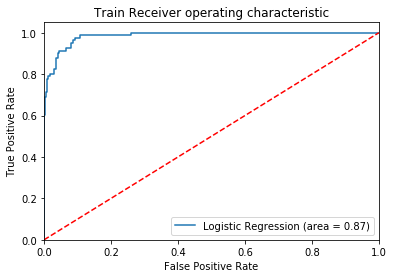

Testing (AUC = 0.95)


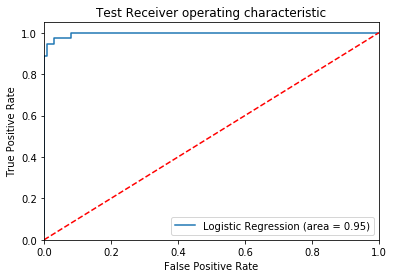

In [28]:
logreg = LogisticRegression()
log_model = calculate_metrics(logreg, X_train_pruned, Y_train, X_test, Y_test, True)

In [ ]:
# Combines coefficients and feature names into a dataframe
coefficients = pd.concat([pd.DataFrame(X_train_pruned.columns, columns = ['Feature']),
                          pd.DataFrame(np.transpose(log_model.coef_), columns = ['Coefficient'])]
                         , axis = 1)
# Calculate p values for all the features excluding the constant
p_vals = p_values(X_train_pruned,Y_train).values[1:]

In [30]:
# Concatenates previous dataframe with the p vals
result_df = pd.concat([coefficients, pd.Series(p_vals, name = 'P Value')], axis = 1)
result_df

,Feature,Coefficient,P Value
0,Min_var_rss12,-0.381761,8.963806e-01
1,Max_avg_rss13,0.200536,1.180668e-01
2,Max_var_rss13,0.513919,1.645600e-01
3,Max_avg_rss23,0.308832,5.016857e-02
4,Mean_var_rss12,-0.980902,5.600244e-01
5,Mean_avg_rss13,-0.304251,2.931937e-02
6,Mean_var_rss13,-0.699079,8.357352e-01
7,Mean_avg_rss23,0.280965,1.639389e-01
8,Mean_var_rss23,0.108772,9.729603e-01
9,Median_avg_rss12,-0.291665,9.657678e-10


From the training and test confusion matrices, we can see that our classifier performs well in overall accuracy but doesn't perfrom the best for correctly identifying the positive class, which in this case is identifying the bending activity. Our dataset has class imbalance and since we are trying to build a classifier that correctly classifies the bending activity, we have to account for class imbalance in our logistic regression model. In sklearn, we can set the class_weight paramter in the logistic regression model to help account for the class imbalance. I fit this model and report the training and testing metrics.

5-Fold K Cross Validation Accuracy: 89.05%
Train Confusion Matrix
[[477  63]
 [  5  76]]
Test Set Accuracy: 93.57%
Test Confusion Matrix
[[124  11]
 [  0  36]]
Trainig (AUC = 0.91)


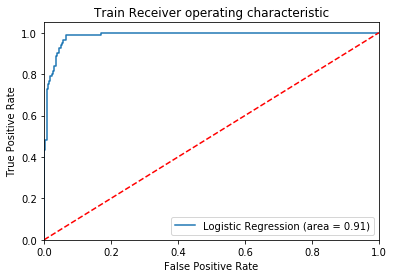

Testing (AUC = 0.96)


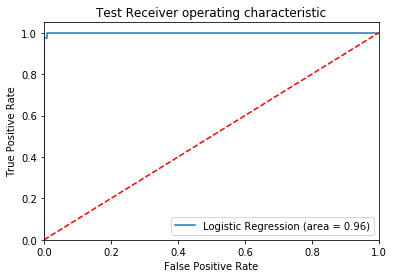

In [31]:
# Refitting a logistic Regression model based on accounting for class imbalance
logreg_case = LogisticRegression(class_weight = 'balanced')
logreg_case_model = calculate_metrics(logreg_case, X_train_pruned, Y_train, X_test, Y_test, True)

As you can see, we get a better classification accuracy of samples belonging to the bending activity, while losing some accuracy and correctly classifying other activities. The small loss in the overall classification accuracy is acceptable.

Next, I will create an L1-penalized logistic regression model to perform binary classification on the dataset. I will cross validate for both l, similar to the previous problem, and C, the weight of L1 penalty. I display the split models in a dataframe similar to the problem above. 

In [32]:
result = best_split(training_instances,'L1')

In [33]:
display_split_models(result, 'L1')

,Number of Splits,Cross Val Accuracy,C value
0,1.0,97.101449,51.020898
1,2.0,94.202899,6.123388
2,3.0,92.753623,2.041796
9,10.0,91.884058,10.204980
5,6.0,91.787440,20.408959
3,4.0,91.666667,46.939306
4,5.0,91.304348,22.449755
6,7.0,91.304348,6.123388
8,9.0,90.499195,12.245776
7,8.0,90.217391,16.327367


In the table above, I chose to use l = 2 for the rest of the problem because we don't want to risk overfitting the data therefore I chose a C value that gave a lower cross val accuracy. 

In [64]:
# After determining the best subset l vaue for prediction accuracy
best_l = 2
# Gets the training and test sets 
X_train,Y_train = instance_split(training_instances,best_l, binary = True) #breaks up time series
X_test,Y_test = instance_split(testing_instances,best_l, binary = True) #breaks up time series

# Normalize the features because we are using l1 penalization
X_train_scaled = normalize(X_train)
X_test_scaled = normalize(X_test)

# Pruned Features and the best C value is returned
X_train_l1, C = prune_features(X_train_scaled,Y_train,'L1') #pruned features
X_test_l1 = X_test_scaled[X_train_l1.columns.values.tolist()] #Takes only columns in train_pruned set


In [65]:
l1_reg = LogisticRegression(penalty = 'l1', dual = False, solver = 'liblinear', C = C, class_weight = 'balanced')
l1_reg_model = calculate_metrics(l1_reg, X_train_l1, Y_train, X_test_l1, Y_test, False)

5-Fold K Cross Validation Accuracy: 90.58%
Train Confusion Matrix
[[109  11]
 [  2  16]]
Test Set Accuracy: 100.00%
Test Confusion Matrix
[[30  0]
 [ 0  8]]


From the results I obtained, it seems like the binomial logistic regression test accuracy for the L1 penalized model is better than the model with variable selection. The L1 penalized was easier to implement because of the built in sklearn packages that cross validated values for the hyperparameter.

In the next section, I attempt to classify the activities based on multiclass labels corresponding to the 7 activities included in the dataset. I fit three classifiers: L1 penalized Multinomial Logistic Regression, Naive Bayes Classifier with Gaussian Priors and Naive Bayes with Multinomial Priors. I compare the three classifiers and report the metrics found from fitting the classifiers to the training data and testing it on the testing data. 

In [ ]:
#Multinomial Classification, prunes the features similar to L1 but now I am using multinomial 
X_train_MC, Y_train_MC = instance_split(training_instances,best_l, binary = False) #breaks up time series

# Pruned Features and the best C value is returned
X_train_MC, C = prune_features(X_train_scaled,Y_train,'Multinomial') #pruned features
X_test_MC = X_test_scaled[X_train_MC.columns.values.tolist()] #Takes only columns in train_pruned set

In [ ]:
#Predicting on the trained model
multilog = LogisticRegression(penalty = 'l1', dual = False, solver = 'saga', C = C, 
                              multi_class = 'multinomial', max_iter = 2000, class_weight = 'balanced')
multilog.fit(X_train_MC, Y_train)


In [68]:
test_predMC = multilog.predict(X_test_MC)
accuracyMC = (metrics.accuracy_score(Y_test, test_predMC))*100 # returns it as a percent value
confusionMC = metrics.confusion_matrix(Y_test, test_predMC)
print('Multinomial L1 Penalized Test Prediction Accuracy: %.02f%%' % accuracyMC)
print('The Confusion Matrix is: ')
print(confusionMC)

Multinomial L1 Penalized Test Prediction Accuracy: 100.00%
The Confusion Matrix is: 
[[30  0]
 [ 0  8]]


In [69]:
GNB = GaussianNB()
GNB.fit(X_train,Y_train)
test_predGNB = GNB.predict(X_test)
accuracyGNB = (metrics.accuracy_score(Y_test, test_predGNB))*100 # returns it as a percent value
confusionGNB = metrics.confusion_matrix(Y_test, test_predGNB)
print('Naive Bayes Gaussian Test Prediction Accuracy: %.02f%%' % accuracyGNB)
print('The Confusion Matrix is: ')
print(confusionGNB)

Naive Bayes Gaussian Test Prediction Accuracy: 52.63%
The Confusion Matrix is: 
[[12 18]
 [ 0  8]]


In [70]:
MNB = MultinomialNB()
MNB.fit(X_train,Y_train)
test_predMNB = MNB.predict(X_test)
accuracyMNB = (metrics.accuracy_score(Y_test, test_predMNB))*100 # returns it as a percent value
confusionMNB = metrics.confusion_matrix(Y_test, test_predMNB)
print('Naive Bayes Multinomial Test Prediction Accuracy: %.02f%%' % accuracyMNB)
print('The Confusion Matrix is: ')
print(confusionMNB)

Naive Bayes Multinomial Test Prediction Accuracy: 94.74%
The Confusion Matrix is: 
[[29  1]
 [ 1  7]]


It seems like the Multinomial L1 logistic Regression classification method worked better on this dataset. This probably resulted from the dataset failing to meet the assumption of a gaussian distribution, which would have in turn made the Naive Bayes multicalssification methods perform better